# Modifies the output of the DeltaSigma dictionary

* Removes the background density from the Sigma profiles. 
* Changes the radius of the $\overline{\Delta\Sigma}$ to include the outer end of the annulus. 

## Setup

In [2]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import h5py
import tables
import pickle5 as pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import pickle
import os
from glob import glob
import scipy

In [3]:
from timeit import default_timer as timer

In [4]:
ptcl_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/'
deltasigma_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/'
clusters_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z0p00/'
data_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/'

## Standardized Scales

In [14]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

In [15]:
##mass bins 
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]

### Computation of background 2d density

In [16]:
from numpy import sqrt

delta=200.0
omega_m=0.3089
omega_l=0.6911
omega_b = 0.0486 
hubble=0.6774
redshift = 0.0
dz = 200 #Mpc, projection depth used in the MDPL2 box.

aexp = 1./(1.+redshift)
Ez = sqrt(omega_m/aexp**3.0+omega_l)
fb = omega_b/omega_m
mu = 0.59
mue = 1.14
delta = float(delta)
erg_to_keV = 624150647.99632

# critical density of the Universe in h^2*Msun/Mpc^3
rho_crit = (2.77536627e11)*(Ez)**2.0

### Background density
rho_bkgr = rho_crit * omega_m
rho_2d_bkgr = rho_bkgr * 2 * dz

In [17]:
print('{:.2g}'.format(rho_bkgr))
print('{:.2g}'.format(rho_2d_bkgr))

8.6e+10
3.4e+13


## Import Files

In [5]:
halo_file = clusters_dir + 'MDPL2_halos_DS_Ngal_Dgal_lt_2_allM_z0p00.p'
matched_halo_df = pickle.load(open(halo_file, 'rb'))

In [6]:
matched_halo_df.dtypes

scale                 float64
id                     object
pid                     int64
mvir                  float64
rvir                  float64
x                     float64
y                     float64
z                     float64
M200b                   int64
M200c                   int64
M500c                   int64
Type                    int64
GalaxyIndex             int64
CentralGalaxyIndex      int64
CtreesHaloID            int64
CtreesCentralID         int64
CentralMvir           float64
StellarMass           float64
Ngal                  float64
cluster_id             object
sigma                  object
r_range                object
delta_sigma            object
dtype: object

### Raw DS files


In [47]:
files = ['sigma_mvir_5e13_1e14_z0p00.pkl','sigma_mvir_1e14_2e14_z0p00.pkl','sigma_mvir_2e14_5e14_z0p00.pkl','sigma_mvir_5e14_1e15_z0p00.pkl']

for file in iter(files):
    print(file)
    with open(data_dir+file, 'rb') as f:
        ds_dict = pickle.load(f)
        
    deltasigma_tilde = np.vstack(ds_dict['delta_sigma'])
    sigma = np.vstack(ds_dict['sigma'])

    deltasigma_mod = np.zeros_like(deltasigma_tilde)
    for i in range(len(r_cent_lin_norm)):
        deltasigma_rbin_tilde = deltasigma_tilde[:,i] #tilde is the previous, wrong version
        sigma_rbin = sigma[:,i]
        sigma_avg_rbin_tilde = deltasigma_rbin_tilde + sigma_rbin ##Tilde stands for the previous, wrong version that needs to be corrected.

        sigma_avg_rbin = ((sigma_avg_rbin_tilde*(r_bins_lin_norm[i]/r_bins_lin_norm[i+1])**2 - rho_2d_bkgr)/(sigma_avg_rbin_tilde - rho_2d_bkgr))*sigma_avg_rbin_tilde + rho_2d_bkgr ##Correct version
        deltasigma_rbin = sigma_avg_rbin - sigma_rbin

        #Add everything together
        deltasigma_mod[:,i] = deltasigma_rbin
        
    ds_dict['delta_sigma']= deltasigma_mod
    ds_dict['sigma']= ds_dict['sigma'] - rho_2d_bkgr
    
    pickle.dump(ds_dict, open(data_dir+file, "wb" ) )

sigma_mvir_5e13_1e14_z0p00.pkl
sigma_mvir_1e14_2e14_z0p00.pkl
sigma_mvir_2e14_5e14_z0p00.pkl
sigma_mvir_5e14_1e15_z0p00.pkl


## Modify one file

In the 1e14-2e14 z=0.00 file there is one faulty cluster deltasigma at the 339th index.

In [10]:
## Obtain the DeltaSigma from the DS files previousl

In [48]:
clusters_z0p00_file = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z0p00/' + 'MDPL2_halos_DS_Ngal_Dgal_lt_2_allM_z0p00_mod.p'

In [49]:
with open(clusters_z0p00_file, 'rb') as handle:
    matched_halo_df = pickle.load(handle)

In [58]:
mass_bin_edges = [1e14, 2e14]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]

In [59]:
from scipy import stats
nBootstrap = 5
X_params = ['T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn']
#X_params = ['c_vir', 'Acc_Rate_2*Tdyn']

#fig, axs = plt.subplots(4,3,figsize=(20,20), tight_layout=True)

for i, cur_mass_bin in enumerate(mass_bins):
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
        print('M{:.2g}-{:.2g}, z={:.2f}'.format(mass_min, mass_max, 1/cur_a_bin-1))
        print(files[i])
        
        with open(data_dir+file, 'rb') as f:
            ds_dict = pickle.load(f)
        
        mask = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max)
        cur_df = matched_halo_df[mask]
        
        DS_cur = np.vstack(cur_df['delta_sigma'])
        ds_dict['delta_sigma'] = DS_cur
        print(ds_dict['cluster_id']-cur_df.cluster_id)
        #print(cur_df.cluster_id)
        
        
#axs[0,0].legend(loc='lower left')

#plt.savefig('cov_time_formation.png')
#plt.show()

M1e+14-2e+14, z=1.03
sigma_mvir_5e13_1e14_z0p00.pkl


ValueError: operands could not be broadcast together with shapes (500,) (431,) 

## Modification of the DataFrame

### Changing radius definition

This needs to be done before changing removing the background density from Sigma. 

We are looking for the 2D density after correcting for the fact that particles are computed inside a circle of radius $R + \Delta R$ but initially the density was computed in a circle of radius $R$. The $\Sigma$ here is computed as the total density = overdensity + background. So we need to be careful here, since the background density does not change by increasing the radius. 

The background density is removed from Sigma in the next step. That needs to be done after this step or else you will get an error. This gives the correct $\Delta\Sigma$ even with no background subtraction since both terms in the substraction include the background and they cancel out. 

In the re-run, I remove the background density before hand and correct the radius definition of the circle so no need for this correction. 

$A^* = \pi*R^2$

$A = \pi*(R+\Delta R)^2$

$\rho_{2d}(<R) = \Sigma(<R) + b$, where b is the background 2D density of the universe. 

$\rho_{2d}(<R + \Delta R) = \Sigma(< R + \Delta R) + b$

$\frac{\Sigma}{\Sigma^*} = \frac{\rho_{2d}^*A^*/A -b}{\rho_{2d}^* -b} $

$\rho_{2d} = \frac{\Sigma}{\Sigma^*} \times \Sigma^* + b$

$\rho_{2d}$ the total 2d density is the term


### Removing background from the Sigma files. 

## Comparison with theory curves

In [21]:
import camb
from camb import model, initialpower

#Set cosmological parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.77, ombh2=0.022, omch2=0.122)
pars.set_dark_energy(w=-1.0)
pars.InitPower.set_params(ns=0.965)

#This sets the k limits and specifies redshifts
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

#Linear P(k)
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 1000)

#Note: the above function has the maxkh argument for specifying a different
#kmax than was used above.
#Note: pk has the shape (N_z, N_k)

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
khnl, znl, pknl = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 1000)

Note: redshifts have been re-sorted (earliest first)


In [22]:
import cluster_toolkit

In [35]:
## Universal parameters
radii = np.logspace(-2, 3, 1000) #Mpc/h comoving
R_perp = np.logspace(-2, 2.4, 1000) #Mpc/h comoving; distance on the sky
mass =2e14 #Msun/h
concentration = 6 #arbitrary
Omega_m = 0.307

In [36]:
from cluster_toolkit import xi
import numpy as np

xi_nfw = xi.xi_nfw_at_r(radii, mass, concentration, Omega_m)

In [37]:
from cluster_toolkit import xi
import numpy as np
#Assume that k and P come from somewhere, e.g. CAMB or CLASS
xi_mm = xi.xi_mm_at_r(radii, kh, pk)

In [38]:
from cluster_toolkit import xi
from cluster_toolkit import bias
import numpy as np

#Assume that k and P come from somewhere, e.g. CAMB or CLASS
xi_mm = xi.xi_mm_at_r(radii, kh, pk)
#Assume that k and P_linear came from somewhere, e.g. CAMB or CLASS
bias = bias.bias_at_M(mass, kh, pk, Omega_m)
xi_2halo = xi.xi_2halo(bias, xi_mm)

In [39]:
from cluster_toolkit import xi
#Calculate 1-halo and 2-halo terms here
xi_hm = xi.xi_hm(xi_nfw, xi_2halo)

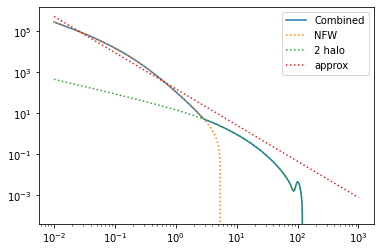

In [40]:
xi_approx_2halo = 10*(radii/4.7)**(-1.77)

plt.plot(radii, xi_hm, label='Combined')
plt.plot(radii, xi_nfw, label='NFW', linestyle='dotted')
plt.plot(radii, xi_2halo, label='2 halo', linestyle='dotted')
plt.plot(radii, xi_approx_2halo, label = 'approx', linestyle='dotted')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [41]:
from cluster_toolkit import deltasigma

#Assume that radii and xi_hm are computed here
Sigma = deltasigma.Sigma_at_R(R_perp, radii, xi_hm, mass, concentration, Omega_m)

In [42]:
from cluster_toolkit import deltasigma
Sigma_nfw = deltasigma.Sigma_nfw_at_R(R_perp, mass, concentration, Omega_m)

In [43]:
from cluster_toolkit import deltasigma

DeltaSigma_theory = deltasigma.DeltaSigma_at_R(R_perp, R_perp, Sigma, mass, concentration, Omega_m)

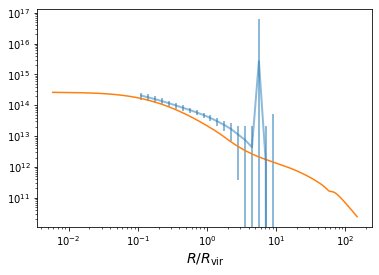

In [44]:
## Plotting all mass bins

#Computing the correlation and covariance for individual mass bins
DS_cur = np.vstack(ds_dict['delta_sigma'])
    
plt.errorbar(r_cent_lin_norm, np.mean(ds_dict['delta_sigma'],axis=0), yerr = np.std(DS_cur,axis=0), label='[{:.2g}, {:.2g})'.format(mass_min, mass_max), linewidth=2, alpha=0.5)
#plt.plot(r_cent_lin_norm, np.mean(deltasigma_raw,axis=0)) 
    
plt.plot(R_perp/1.7, DeltaSigma_theory*1e12 , label='theory')
#DS_all = np.vstack(matched_halo_df['delta_sigma'])
#plt.errorbar(r_cent_lin_norm, np.mean(DS_all,axis=0), yerr = np.std(DS_all,axis=0), label='All', linewidth=2, alpha=1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
#plt.legend()
plt.show()

In [28]:
### look into the problematic 1e14-2e14 DeltaSigma at index 17

## Saving the files

In [42]:
pickle.dump(matched_halo_df, open( clusters_dir+ "MDPL2_halos_DS_Ngal_Dgal_lt_2_allM_z0p00_mod.p", "wb" ) )